In [1]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
from nilearn import plotting
import nibabel as nib
import itertools

from bold_dementia.connectivity import Atlas, group_by_networks, plot_matrix, reshape_pvalues
from bold_dementia.utils.iterables import unique

ATLAS = "msdl"
SOFT = True
ALPHA = config["alpha"]

In [2]:
atlas = Atlas.from_name(ATLAS, soft=SOFT)
coords = atlas.get_coords()

In [15]:
matrices_path = Path(
    f"{config['output_dir']}/connectivity/atlas-{ATLAS}_global-signal"
)
print(f"Loading matrices from {matrices_path}")
AD_matrices = joblib.load(matrices_path / "AD.joblib")
control_matrices = joblib.load(matrices_path / "control.joblib")
fdrmat = joblib.load(matrices_path / "pmat.joblib")
tstats = joblib.load(matrices_path / "statmap.joblib")



n_AD = AD_matrices.shape[0]
n_controls = control_matrices.shape[0]

atlas = Atlas.from_name(ATLAS, soft=SOFT)
n_regions = len(atlas.labels)

Loading matrices from /homes_unix/jlegrand/data/Memento/output/connectivity/atlas-msdl_global-signal


In [71]:
tstats[tstats > 0.05]

array([0.05468235, 0.06322799, 0.05958417, 0.05780798, 0.08816306,
       0.06705168, 0.08468637, 0.06053009, 0.06327157, 0.0788013 ,
       0.06216978, 0.06868196, 0.07027683, 0.05027145, 0.06393006,
       0.0574224 , 0.07668014, 0.07431704, 0.05378449, 0.05239295,
       0.06053009, 0.05007095, 0.06705168, 0.06322799, 0.08371913,
       0.06452944, 0.05063218, 0.05958417, 0.05027145, 0.0574224 ,
       0.05847161, 0.05220564, 0.08468637, 0.06327157, 0.05559367,
       0.0788013 , 0.05478427, 0.07028887, 0.0735343 , 0.06558074,
       0.0735343 , 0.06260843, 0.10785972, 0.08371913, 0.06558074,
       0.11636143, 0.05468235, 0.05780798, 0.06216978, 0.07668014,
       0.05478427, 0.07572567, 0.05872433, 0.06868196, 0.07027683,
       0.07431704, 0.05847161, 0.06452944, 0.05220564, 0.07028887,
       0.05007095, 0.05063218, 0.08816306, 0.06393006, 0.05378449,
       0.06260843, 0.10785972, 0.11636143, 0.06380088, 0.05239295,
       0.05559367, 0.07572567, 0.05872433, 0.06380088])

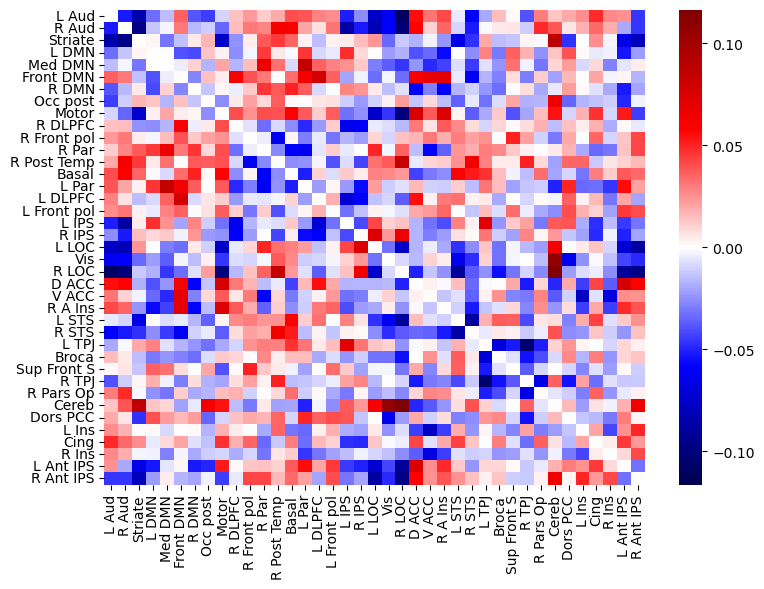

In [76]:
from bold_dementia.connectivity import plot_ordered_matrix

plot_ordered_matrix(tstats, atlas)
plt.show()

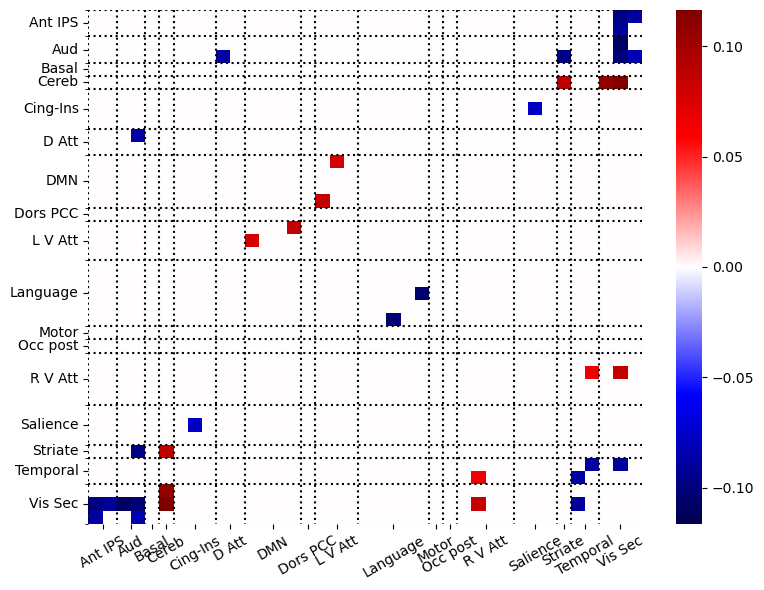

In [66]:
thresholded_t = tstats * np.where(fdrmat < ALPHA, 1, 0)
plot_matrix(thresholded_t, atlas, True)
plt.show()

In [19]:
ticks, sort_index = group_by_networks(atlas.macro_labels)
block_mat = thresholded_t[np.ix_(sort_index, sort_index)]
ticks

Ant IPS
Aud
Basal
Cereb
Cing-Ins
D Att
DMN
Dors PCC
L V Att
Language
Motor
Occ post
R V Att
Salience
Striate
Temporal
Vis Sec


[0, 2, 4, 5, 6, 9, 11, 15, 16, 19, 24, 25, 26, 30, 33, 34, 36, 39]

In [20]:
unique_m = sorted(tuple(unique(atlas.macro_labels)))
network_to_idx = pd.Series(dict(zip(
    unique_m,
    itertools.pairwise(ticks)
)))
network_to_idx

Ant IPS       (0, 2)
Aud           (2, 4)
Basal         (4, 5)
Cereb         (5, 6)
Cing-Ins      (6, 9)
D Att        (9, 11)
DMN         (11, 15)
Dors PCC    (15, 16)
L V Att     (16, 19)
Language    (19, 24)
Motor       (24, 25)
Occ post    (25, 26)
R V Att     (26, 30)
Salience    (30, 33)
Striate     (33, 34)
Temporal    (34, 36)
Vis Sec     (36, 39)
dtype: object

In [11]:
# TODO Allow (self, self) with chaining
def block_count(matrix, network_to_idx, combinations=itertools.combinations):
    for network_a, network_b in combinations(network_to_idx.index, 2):
            loc_a, loc_b = network_to_idx[network_a], network_to_idx[network_b]
            block = matrix[loc_a[0]:loc_a[1], loc_b[0]:loc_b[1]]
            n_positive_edges = np.count_nonzero(block > 0)
            n_negative_edges = np.count_nonzero(block < 0)
            
            block_size = (loc_a[1] - loc_a[0]) * (loc_b[1] - loc_b[0])
            block_activation = (n_negative_edges + n_negative_edges) / block_size

            yield network_a, network_b, n_positive_edges, n_negative_edges, block_activation

def intra_network_count(matrix, network_to_idx):
    intra_network = map(lambda x: (x, x), network_to_idx.index)
    for network_a, network_b in intra_network:
            loc_a, loc_b = network_to_idx[network_a], network_to_idx[network_b]
            block = matrix[loc_a[0]:loc_a[1], loc_b[0]:loc_b[1]]
            n_positive_edges = np.count_nonzero(block > 0)
            n_negative_edges = np.count_nonzero(block < 0)
            
            block_size = (loc_a[1] - loc_a[0]) * (loc_b[1] - loc_b[0])
            block_activation = (n_negative_edges + n_negative_edges) / block_size

            yield network_a, network_b, n_positive_edges, n_negative_edges, block_activation


In [21]:
from itertools import product
def block_block(matrix, network_to_idx):
    for network_a, network_b in product(network_to_idx.index, network_to_idx.index):
            loc_a, loc_b = network_to_idx[network_a], network_to_idx[network_b]
            block = matrix[loc_a[0]:loc_a[1], loc_b[0]:loc_b[1]]
            n_positive_edges = np.count_nonzero(block > 0)
            n_negative_edges = np.count_nonzero(block < 0)
            
            block_size = (loc_a[1] - loc_a[0]) * (loc_b[1] - loc_b[0])
            block_activation = (n_negative_edges + n_negative_edges) / block_size

            yield network_a, network_b, n_positive_edges, n_negative_edges, block_activation
        

In [27]:
gen = block_block(block_mat, network_to_idx)
comparisons = pd.DataFrame(gen, columns=["node_a", "node_b", "npos", "nneg", "activation"])

3

In [47]:
comparisons_pv = comparisons.pivot(index="node_a", columns="node_b")

node_b
Ant IPS     0
Aud         0
Basal       0
Cereb       2
Cing-Ins    0
D Att       0
DMN         2
Dors PCC    0
L V Att     2
Language    0
Motor       0
Occ post    0
R V Att     1
Salience    0
Striate     1
Temporal    1
Vis Sec     2
dtype: int64

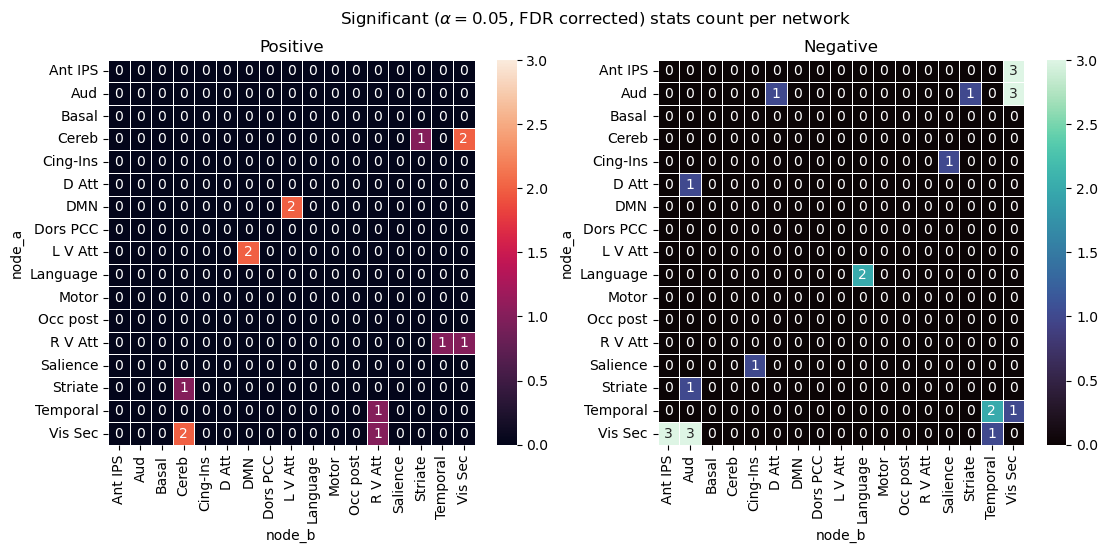

In [53]:
max_count = max(comparisons[["npos", "nneg"]].max())

heat_kwargs = {
    "xticklabels":unique_m,
    "yticklabels":unique_m,
    "vmax": max_count,
    "annot": True,
    "linewidth": 0.5
}

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(comparisons_pv.loc[:, "npos"], **heat_kwargs, cmap="rocket", ax=axes[0])
axes[0].set_title("Positive")

sns.heatmap(comparisons_pv.loc[:, "nneg"], **heat_kwargs, cmap="mako", ax=axes[1])
axes[1].set_title("Negative")
fig.suptitle(f"Significant ($\\alpha = 0.05$, FDR corrected) stats count per network")
fig.show()

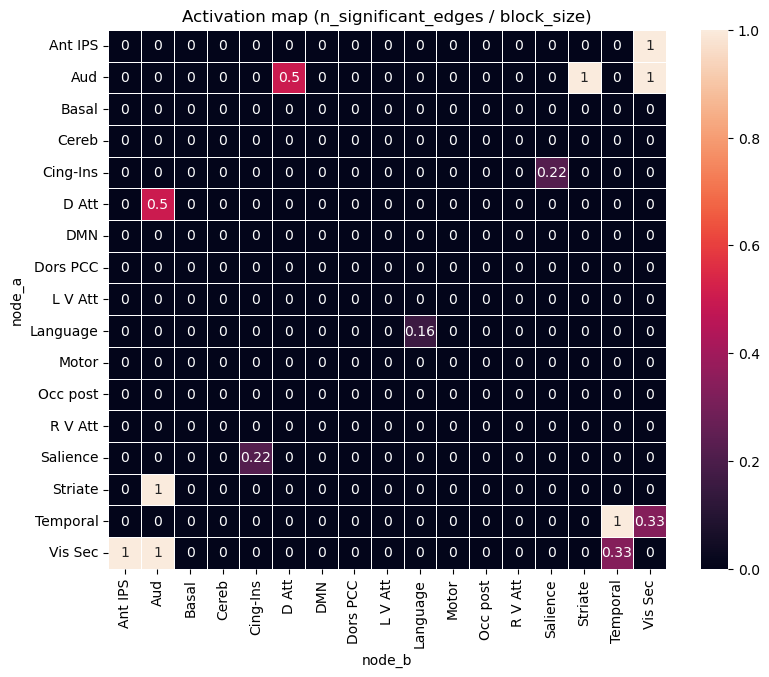

In [58]:
heat_k2 = heat_kwargs.copy()
heat_k2.pop("vmax")
plt.subplots(1, 1, figsize=(9, 7))
sns.heatmap(comparisons_pv.loc[:, "activation"], **heat_k2)
plt.title("Activation map (n_significant_edges / block_size)")
plt.show()

In [ ]:
view = plotting.view_connectome(thresholded_t, coords, edge_threshold="90%")
view.open_in_browser()